In [1]:
import SimpleITK as sitk
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from skimage import io
from sklearn.utils import shuffle
from PIL import Image

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
def find_images(path_dir, path_nor, path_t):
    num=10
    X_train=np.zeros(((274)*num,240,240),dtype=np.uint16)
    Y_train=np.zeros(((274)*num,2),dtype=np.uint16)
#     X_train=np.zeros(((274+109)*num+842,240,240),dtype=np.uint16)
#     Y_train=np.zeros(((274+109)*num+842,2),dtype=np.uint16)
    j=0
    for item in os.listdir(path_dir):
        item=os.path.join(path_dir,item)
        for item2 in os.listdir(item):
            im ={'T1':None,'gt':None}
            item2=os.path.join(item,item2)
            for item3 in os.listdir(item2):
                item3=os.path.join(item2,item3)
                for item4 in os.listdir(item3):
                    item5=os.path.join(item3,item4)
                    if os.path.isfile(item5) and item5.endswith('.mha'):
                        itk_image = sitk.ReadImage(item5)
                        nd_image = sitk.GetArrayFromImage(itk_image)
                        if 'more' in item5 or 'OT' in item5:
                            im['gt']=nd_image
                        elif 'T1' in item5 and 'T1c' not in item5:
                            im['T1']=nd_image
            for i in range(70,70+num):
                if not sum(sum(im['gt'][i,:,:])): #sum=0 normal brains
                    Y_train[j][0]=1
                else:
                    Y_train[j][1]=1
                X_train[j]=im['T1'][i,:,:]
                j+=1
#     for item in os.listdir(path_nor):
#         item2 = os.path.join(path_nor,item)
#         img = nib.load(item2)
#         data=img.get_fdata()
#         for i in range(90,90+num):
#             Y_train[j][0]=1
#             X_train[j]=resize(data[50:210,i,:],(240,240))
#             j+=1
#     for item in os.listdir(path_t):
#         item2=os.path.join(path_t,item)
#         for item3 in os.listdir(item2):
#             item5=os.path.join(item2,item3)
#             if os.path.isfile(item5) and item5.endswith('.jpg'):
#                 image = io.imread(item5,as_gray=True)
#                 image = resize(image,(240,240))
#                 X_train[j]=image
#                 if item == 'abnormalsJPG':
#                     Y_train[j][1]=1
#                 elif item == 'normalsJPG':
#                     Y_train[j][0]=1
#                 j+=1
    return X_train,Y_train

In [5]:
path_t="./normalsVsAbnormalsV1"
X_train,Y_train=find_test_images(path_t,842)

normalsJPG
0
480
abnormalsJPG
362
480


In [4]:
path_dir="./BRATS2015_Training"
path_nor="./nii"
path_t="./normalsVsAbnormalsV1"
X_train,Y_train=find_images(path_dir, path_nor, path_t)
# X_train,Y_train=find_images(path_dir)

In [6]:
shape=X_train.shape
maxi = np.amax(X_train)
X_train = X_train/maxi
X_train=X_train.reshape(shape[0],shape[1],shape[2],1)
X_train.shape

(842, 240, 240, 1)

In [30]:
np.random.seed(1000)
model=Sequential()

model.add(Conv2D(filters=96, input_shape=(240,240,1), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(11,11),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation(tf.nn.softmax))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 58, 58, 96)        11712     
_________________________________________________________________
activation_9 (Activation)    (None, 58, 58, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 29, 29, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 19, 19, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 256)         0         
__________

In [ ]:
# from pdb import set_trace as trace
# trace()
X_train, Y_train = shuffle(X_train, Y_train)
model_checkpoint = ModelCheckpoint('Alexnet_brat.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit(X_train,Y_train,batch_size=32,epochs=200,verbose=1,validation_split=0.1,shuffle=True, callbacks=[model_checkpoint])

Train on 757 samples, validate on 85 samples
Epoch 1/200
757/757 [==============================] - 4s 5ms/step - loss: 3.2772 - acc: 0.6909 - val_loss: 6.4472 - val_acc: 0.6000

Epoch 00001: val_loss improved from inf to 6.44724, saving model to Alexnet_brat.hdf5
Epoch 2/200
757/757 [==============================] - 3s 4ms/step - loss: 1.5094 - acc: 0.8203 - val_loss: 5.0509 - val_acc: 0.6235

Epoch 00002: val_loss improved from 6.44724 to 5.05088, saving model to Alexnet_brat.hdf5
Epoch 3/200
757/757 [==============================] - 3s 4ms/step - loss: 0.4410 - acc: 0.8600 - val_loss: 1.6137 - val_acc: 0.7529

Epoch 00003: val_loss improved from 5.05088 to 1.61370, saving model to Alexnet_brat.hdf5
Epoch 4/200
757/757 [==============================] - 3s 4ms/step - loss: 0.3750 - acc: 0.8798 - val_loss: 0.4202 - val_acc: 0.8588

Epoch 00004: val_loss improved from 1.61370 to 0.42016, saving model to Alexnet_brat.hdf5
Epoch 5/200
757/757 [==============================] - 3s 4ms/s


Epoch 00042: val_loss did not improve from 0.06116
Epoch 43/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0051 - acc: 0.9987 - val_loss: 0.1821 - val_acc: 0.9647

Epoch 00043: val_loss did not improve from 0.06116
Epoch 44/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0127 - acc: 0.9947 - val_loss: 0.2649 - val_acc: 0.9647

Epoch 00044: val_loss did not improve from 0.06116
Epoch 45/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0207 - acc: 0.9960 - val_loss: 0.2096 - val_acc: 0.9647

Epoch 00045: val_loss did not improve from 0.06116
Epoch 46/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0092 - acc: 0.9960 - val_loss: 0.1991 - val_acc: 0.9765

Epoch 00046: val_loss did not improve from 0.06116
Epoch 47/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0696 - acc: 0.9841 - val_loss: 0.9490 - val_acc: 0.8706

Epoch 00047: val_loss did not improve from 0.06116
Epoch 48/200
757/7


Epoch 00086: val_loss did not improve from 0.06116
Epoch 87/200
757/757 [==============================] - 3s 4ms/step - loss: 8.4903e-05 - acc: 1.0000 - val_loss: 0.2399 - val_acc: 0.9647

Epoch 00087: val_loss did not improve from 0.06116
Epoch 88/200
757/757 [==============================] - 3s 4ms/step - loss: 9.6009e-04 - acc: 1.0000 - val_loss: 0.3684 - val_acc: 0.9294

Epoch 00088: val_loss did not improve from 0.06116
Epoch 89/200
757/757 [==============================] - 3s 4ms/step - loss: 8.6401e-04 - acc: 1.0000 - val_loss: 0.3359 - val_acc: 0.9529

Epoch 00089: val_loss did not improve from 0.06116
Epoch 90/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0192 - acc: 0.9947 - val_loss: 0.4066 - val_acc: 0.9529

Epoch 00090: val_loss did not improve from 0.06116
Epoch 91/200
757/757 [==============================] - 3s 4ms/step - loss: 0.0156 - acc: 0.9934 - val_loss: 0.3259 - val_acc: 0.9412

Epoch 00091: val_loss did not improve from 0.06116
Epoch 

In [ ]:
plt.imshow(X_train[30,:,:,0])

In [ ]:
Y_train[13699]

In [4]:
def find_test_images(path_dir,num):
    X_test=np.zeros((num,240,240),dtype=np.uint16)
    Y_test=np.zeros((num,2),dtype=np.uint16)
    j=0
    k=0
    l=0
    for item in os.listdir(path_dir):
        item2=os.path.join(path_dir,item)
        for item3 in os.listdir(item2):
            item5=os.path.join(item2,item3)
            if os.path.isfile(item5) and item5.endswith('.jpg'):
                image = Image.open(item5).convert('L')
                image = image.resize((240,240),Image.ANTIALIAS)
                X_test[j]=image
                if item == 'abnormalsJPG':
                    Y_test[j][1]=1
                    k+=1
                elif item == 'normalsJPG':
                    Y_test[j][0]=1
                    l+=1
                j+=1
        print(item)
        print(k)
        print(l)
    return X_test,Y_test

In [9]:
test_path="./test"
X_test,Y_test = find_test_images(test_path,100)

normalsJPG
0
50
abnormalsJPG
50
50


In [10]:
X1_test=X_test/maxi
# X1_test = X_test
shape=X1_test.shape
X1_test=X1_test.reshape(shape[0],shape[1],shape[2],1)

In [26]:
# model.load_weights("./run4/Alexnet_brat.hdf5")
results = model.predict(X1_test,verbose=1)

100/100 [==============================] - 0s 1ms/step


In [27]:
score, acc = model.evaluate(X1_test, Y_test,
                            batch_size=32)

100/100 [==============================] - 0s 1ms/step


In [28]:
score, acc

(4.628885804677847, 0.5)

In [29]:
results

array([[9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.5376708e-05],
       [9.9990463e-01, 9.

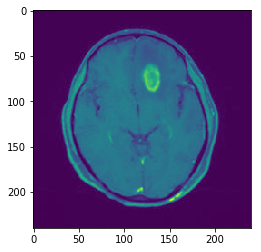

In [18]:
plt.imshow(X1_test[50].reshape(240,240))

In [25]:
arr= io.imread('./test/abnormalsJPG/IMG-0001-00001.jpg',as_gray=True)
arr.shape

(227, 227)

In [ ]:
# np.random.seed(1000)
# model=Sequential()

# model.add(Conv2D(filters=96, input_shape=(240,240,1), kernel_size=(11,11), strides=(4,4), padding='valid'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
# model.add(BatchNormalization())

# model.add(Conv2D(filters=256,kernel_size=(11,11),strides=(1,1),padding='valid'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
# model.add(BatchNormalization())

# model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='valid'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(4096))
# model.add(Activation('relu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Dense(4096))
# model.add(Activation('relu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Dense(2))
# model.add(Activation('sigmoid'))

# model.summary()

# model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

In [ ]:
# datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# datagen.fit(X_train)
# model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
#                     steps_per_epoch=len(X_train) / 32, epochs=10)